# Image Style Transfer

![alt text](https://bloglunit.files.wordpress.com/2017/04/e18489e185b3e1848fe185b3e18485e185b5e186abe18489e185a3e186ba-2017-05-16-e1848be185a9e18492e185ae-1-50-07.png)

- A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576)
- Pretrained ResNet50
- Reference below
- https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
- https://github.com/leongatys/PytorchNeuralStyleTransfer

In [1]:
!pip install torch torchvision

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [2]:
# 필요한 이미지들을 다운받습니다.

!rm -r images
import os 

try:
  os.mkdir("images")
  os.mkdir("images/content")
  os.mkdir("images/style")
except:
  pass

!wget https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg -P images/content
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg -P images/style

'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


## 1. Settings
### 1) Import required libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

### 2) Hyperparameter

In [4]:
# 컨텐츠 손실을 어느 지점에서 맞출것인지 지정해놓습니다.
content_layer_num = 1
image_size = 512
epoch = 5000

## 2. Data
### 1) Directory

In [5]:
content_dir = "./images/content/Tuebingen_Neckarfront.jpg"
style_dir = "./images/style/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

### 2) Prepocessing Function
- 전처리 함수

In [6]:
# 이미 학습된 ResNet 모델이 이미지넷으로 학습된 모델이기 때문에 이에 따라 정규화해줍니다.

def image_preprocess(img_dir):
    img = Image.open(img_dir)
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], 
                                         std=[1,1,1]),
                ])
    img = transform(img).view((-1,3,image_size,image_size))
    return img

### 3) Post processing Function
- 후처리 함수

In [7]:
# 정규화 된 상태로 연산을 진행하고 다시 이미지화 해서 보기위해 뺐던 값들을 다시 더해줍니다.
# 또한 이미지가 0에서 1사이의 값을 가지게 해줍니다.

def image_postprocess(tensor):
    transform = transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], 
                                     std=[1,1,1])
    img = transform(tensor.clone())
    img = img.clamp(0,1)
    img = torch.transpose(img,0,1)
    img = torch.transpose(img,1,2)
    return img

## 3. Model & Loss Function
### 1) Resnet

In [8]:
# 미리 학습된 resnet50를 사용합니다.
resnet = models.resnet50(pretrained=True)
for name,module in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


### 2) Delete Fully Connected Layer

In [9]:
# 레이어마다 결과값을 가져올 수 있게 forward를 정의합니다.

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet,self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7])
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8])

    def forward(self,x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)
        return out_0, out_1, out_2, out_3, out_4, out_5

### 3) Gram Matrix Function

In [10]:
# 그람 행렬을 생성하는 클래스 및 함수를 정의합니다. 
# [batch,channel,height,width] -> [b,c,h*w]
# [b,c,h*w] x [b,h*w,c] = [b,c,c]

class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        return G

### 4) Model on GPU

In [11]:
# 모델을 학습의 대상이 아니기 때문에 requires_grad를 False로 설정합니다.
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

resnet = Resnet().to(device)
for param in resnet.parameters():
    param.requires_grad = False

cpu


### 5) Gram Matrix Loss

In [12]:
# 그람행렬간의 손실을 계산하는 클래스 및 함수를 정의합니다.

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

## 4. Train
### 1) Prepare Images

False False True


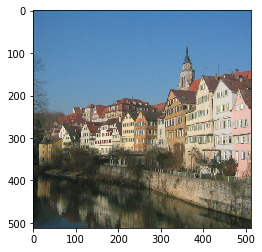

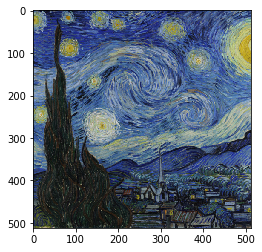

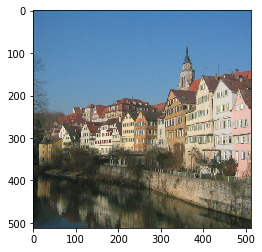

In [13]:
# 컨텐츠 이미지, 스타일 이미지, 학습의 대상이 되는 이미지를 정의합니다.

content = image_preprocess(content_dir).to(device)
style = image_preprocess(style_dir).to(device)
generated = content.clone().requires_grad_().to(device)

print(content.requires_grad,style.requires_grad,generated.requires_grad)

# 각각을 시각화 합니다.

plt.imshow(image_postprocess(content[0].cpu()))
plt.show()

plt.imshow(image_postprocess(style[0].cpu()))
plt.show()

gen_img = image_postprocess(generated[0].cpu()).data.numpy()
plt.imshow(gen_img)
plt.show()

### 2) Set Targets & Style Weights

In [14]:
# 목표값을 설정하고 행렬의 크기에 따른 가중치도 함께 정의해놓습니다

style_target = list(GramMatrix().to(device)(i) for i in resnet(style))
content_target = resnet(content)[content_layer_num]
style_weight = [1/n**2 for n in [64,64,256,512,1024,2048]]

### 3) Train

In [15]:
# LBFGS 최적화 함수를 사용합니다.
# 이때 학습의 대상은 모델의 가중치가 아닌 이미지 자체입니다.
# for more info about LBFGS -> http://pytorch.org/docs/optim.html?highlight=lbfgs#torch.optim.LBFGS

optimizer = optim.LBFGS([generated])

iteration = [0]
while iteration[0] < epoch:
    def closure():
        optimizer.zero_grad()
        out = resnet(generated)
        
        # 스타일 손실을 각각의 목표값에 따라 계산하고 이를 리스트로 저장합니다.
        style_loss = [GramMSELoss().to(device)(out[i],style_target[i])*style_weight[i] for i in range(len(style_target))]
        
        # 컨텐츠 손실은 지정한 위치에서만 계산되므로 하나의 수치로 저장됩니다.
        content_loss = nn.MSELoss().to(device)(out[content_layer_num],content_target)
        
        # 스타일:컨텐츠 = 1000:1의 비중으로 총 손실을 계산합니다.
        total_loss = 1000 * sum(style_loss) + torch.sum(content_loss)
        total_loss.backward()

        if iteration[0] % 100 == 0:
            print(total_loss)
        iteration[0] += 1
        return total_loss

    optimizer.step(closure)

tensor(1515819.5000, grad_fn=<AddBackward0>)
tensor(42.1782, grad_fn=<AddBackward0>)
tensor(7.4412, grad_fn=<AddBackward0>)
tensor(2.7221, grad_fn=<AddBackward0>)
tensor(1.4483, grad_fn=<AddBackward0>)
tensor(0.9457, grad_fn=<AddBackward0>)
tensor(0.6721, grad_fn=<AddBackward0>)
tensor(0.5105, grad_fn=<AddBackward0>)
tensor(0.4113, grad_fn=<AddBackward0>)
tensor(0.3476, grad_fn=<AddBackward0>)
tensor(0.3025, grad_fn=<AddBackward0>)
tensor(0.2688, grad_fn=<AddBackward0>)
tensor(0.2423, grad_fn=<AddBackward0>)
tensor(0.2220, grad_fn=<AddBackward0>)
tensor(0.2055, grad_fn=<AddBackward0>)
tensor(0.1925, grad_fn=<AddBackward0>)
tensor(0.1816, grad_fn=<AddBackward0>)
tensor(0.1726, grad_fn=<AddBackward0>)
tensor(0.1649, grad_fn=<AddBackward0>)
tensor(0.1580, grad_fn=<AddBackward0>)
tensor(0.1524, grad_fn=<AddBackward0>)
tensor(0.1475, grad_fn=<AddBackward0>)
tensor(0.1430, grad_fn=<AddBackward0>)
tensor(0.1390, grad_fn=<AddBackward0>)
tensor(0.1357, grad_fn=<AddBackward0>)
tensor(0.1325, gra

## 5. Check Results

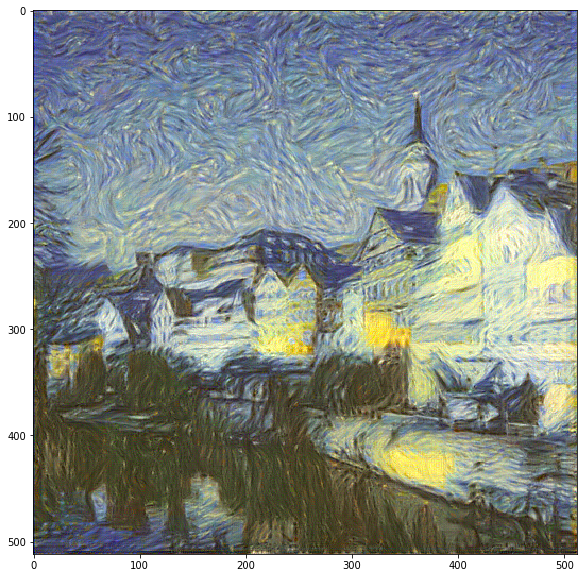

In [16]:
# 학습된 결과 이미지를 확인합니다.

gen_img = image_postprocess(generated[0].cpu()).data.numpy()

plt.figure(figsize=(10,10))
plt.imshow(gen_img)
plt.show()